# Imports

In [1]:
import random
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.datasets import STL10

import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utils

In [4]:
def tsne(ssl, loader,):
    figure(figsize=(16, 12), dpi=80)
    with warnings.catch_warnings():
        # ignore all caught warnings
        warnings.filterwarnings("ignore")
        feature_extractor = ssl.resnet
        count=0
        for img, label in loader:
            out = feature_extractor(img.to(device))
            # print(out.shape)
            preds = torch.argmax(ssl(img.to(device)), dim=1)
            X_embedded = TSNE(n_components=2, learning_rate='auto', random_state=24, init='pca').fit_transform(out.detach().numpy())
            # print(X_embedded.shape)
            # plt.hold(True)
            plt.title("TSNE Visualization of the Latent Space")
            plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=label.numpy())
            plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=preds.numpy(), s=(30 * np.ones(32))**2, alpha=0.2)
            break

In [5]:
def get_accuracies(model, loader):
  total_correct = 0
  model.eval()
  for img, label in loader:
    out = model(img.to(device))
    pred = torch.argmax(out, dim=1)
    total_correct += torch.sum(pred==label.to(device))
  return total_correct

In [6]:
class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            sigma = random.random() * 1.9 + 0.1
            return img.filter(ImageFilter.GaussianBlur(sigma))
        else:
            return img

class Solarization(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

In [8]:
from PIL import Image, ImageOps, ImageFilter

class Barlo_Transform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(224, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                        saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(p=1.0),
            Solarization(p=0.0),
            transforms.ToTensor(),
            # transforms.Resize((32, 32))
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                #  std=[0.229, 0.224, 0.225])
        ])
        self.transform_prime = transforms.Compose([
            transforms.RandomResizedCrop(224, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                        saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(p=0.1),
            Solarization(p=0.2),
            transforms.ToTensor(),
            # transforms.Resize((32, 32))
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                #  std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        y1 = self.transform(x)
        y2 = self.transform_prime(x)
        return y1, y2


# Data Loading

In [9]:
STL10_LABELED_SET  = STL10("/content/drive/MyDrive/LABELED", download=False, transform=transforms.Compose([transforms.ToTensor(),]), split="train")
STL10_LABELED_SET_TRAIN, STL10_LABELED_SET_VAL = torch.utils.data.random_split(STL10_LABELED_SET, [4500, 500])
STL10_UNLABELED_SET = STL10("/content/drive/MyDrive/UNLABELED", download=False, transform=Barlo_Transform(), split="unlabeled")
STL10_UNLABELED_SET_TRAIN, STL10_UNLABELED_SET_VAL = torch.utils.data.random_split(STL10_UNLABELED_SET, [90000, 10000])
STL10_TEST_SET  = STL10("/content/drive/MyDrive/TEST", download=False, transform=transforms.Compose([transforms.ToTensor(), ]), split="test")

In [10]:
STL10_LABELED_LOADER_TRAIN = torch.utils.data.DataLoader(STL10_LABELED_SET_TRAIN, batch_size = 32, shuffle=True, )
STL10_LABELED_LOADER_VAL = torch.utils.data.DataLoader(STL10_LABELED_SET_VAL, batch_size = 32, shuffle=True, )
STL10_UNLABELED_LOADER_TRAIN = torch.utils.data.DataLoader(STL10_UNLABELED_SET_TRAIN, batch_size = 32, shuffle=True,)
STL10_UNLABELED_LOADER_VAL = torch.utils.data.DataLoader(STL10_UNLABELED_SET_VAL, batch_size = 32, shuffle=True,)
STL10_TEST_LOADER = torch.utils.data.DataLoader(STL10_TEST_SET, batch_size = 32, shuffle=True)

# Models

In [11]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = torchvision.models.resnet18(pretrained=False)
    self.conv1.classifier = nn.Identity()
    self.linear1 = nn.Linear(1000, 256)
    self.dropout = nn.Dropout(0.4)
    self.linear2 = nn.Linear(256, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.linear1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    return F.log_softmax(x, dim=1)

In [12]:
class BarlowTwins(nn.Module):
    def __init__(self,):
        super().__init__()
        self.backbone = torchvision.models.resnet18()
        self.backbone.classifier = nn.Identity()
        self.projector = nn.Sequential(nn.Linear(1000, 512, bias=False), nn.BatchNorm1d(512), nn.ReLU(), nn.Linear(512, 512, bias = False), nn.BatchNorm1d(512))

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(512, affine=False)



    def forward(self, y1, y2):
        z1 = self.projector(self.backbone(y1))
        z2 = self.projector(self.backbone(y2))

        # empirical cross-correlation matrix
        c = self.bn(z1).T @ self.bn(z2)

        # sum the cross-correlation matrix between all gpus
        c.div_(32)
        # torch.distributed.all_reduce(c)

        def off_diagonal(x):
          # return a flattened view of the off-diagonal elements of a square matrix
          n, m = x.shape
          assert n == m
          return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()
        loss = on_diag + 0.0051 * off_diag
        return loss


# Training Logics

In [13]:
def train_supervised(model, train_loader, criterion, optimizer, num_epochs, val_loader=None, device=torch.device("cpu")):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []
  train_size = len(train_loader.dataset)
  val_size = len(val_loader.dataset)
  for e in trange(num_epochs):
    model.train()
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_correct = 0
    epoch_val_correct = 0
    for img, label in train_loader:
      out = model(img.to(device))
      loss = F.nll_loss(out, label.to(device))
      optimizer.zero_grad()
      loss.backward()
      epoch_train_losses.append(loss.item())
      optimizer.step()
      pred = torch.argmax(out, dim=1)
      epoch_train_correct += torch.sum(pred==label.to(device))
    train_losses.append(torch.tensor(epoch_train_losses).mean().item())
    train_accs.append(epoch_train_correct/train_size*100)

    model.eval()
    with torch.no_grad():
      for img, label in val_loader:
        out = model(img.to(device))
        loss = F.nll_loss(out, label.to(device))
        epoch_val_losses.append(loss.item())
        pred = torch.argmax(out, dim=1)
        epoch_val_correct += torch.sum(pred==label.to(device))
    val_losses.append(torch.tensor(epoch_val_losses).mean().item())
    val_accs.append(epoch_val_correct/val_size*100)
    print(f"Epoch: {e}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]} Train Accs: {train_accs[-1]}, Val Accs: {val_accs[-1]}")
    # torch.save(model, f"/content/drive/MyDrive/Supervised(epoch_{e}).pth")
    torch.save(model, f"/content/drive/MyDrive/Supervised(epoch_{e})SSL.pth")
  return train_losses, val_losses, train_accs, val_accs

In [14]:
def train_barlo(model, train_loader, criterion, optimizer, num_epochs, val_loader=None,  device=torch.device("cpu")):
  train_losses = []
  val_losses = []
  model.train()
  for e in trange(num_epochs):
    epoch_train_losses = []
    epoch_val_losses = []
    for idx, things in enumerate(tqdm(train_loader)):
      imgs, labels = things
      x1, x2 = imgs
      loss = model(x1.to(device), x2.to(device))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_train_losses.append(loss.item())
    train_losses.append(torch.tensor(epoch_train_losses).mean().item())

    with torch.no_grad():
      for idx, things in enumerate(tqdm(val_loader)):
        imgs, labels = things
        x1, x2 = imgs
        loss = model(x1.to(device), x2.to(device))
        epoch_val_losses.append(loss.item())
    val_losses.append(torch.tensor(epoch_val_losses).mean().item())
    print(f"Epoch: {e}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")
    torch.save(model, f"/content/drive/MyDrive/Barlo{e}.pth")
  return train_losses, val_losses

In [15]:
def train_semi_supervised(model, labeled_loader, unlabeled_loader, optimizer, num_epochs, device=torch.device("cpu")):

  # Instead of using current epoch we use a "step" variable to calculate alpha_weight
  # This helps the model converge faster


  def alpha_weight(step):
    T1 = 100
    T2 = 700
    af = 3
    if step < T1:
      return 0.0
    elif step > T2:
      return af
    else:
      return ((step-T1) / (T2-T1))*af

  step = 100 

  labeled_losses = []
  unlabeled_losses = []

  for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_losses_labeled = []
    epoch_losses_unlabeled = []
    for batch_idx, things in enumerate(tqdm(unlabeled_loader)):
      imgs, labels = things
      # Forward Pass to get the pseudo labels
      x_unlabeled = imgs.to(device)
      model.eval()
      output_unlabeled = model(x_unlabeled)
      _, pseudo_labeled = torch.max(output_unlabeled, 1)

      model.train()
      # Now calculate the unlabeled loss using the pseudo label
      output = model(x_unlabeled)
      unlabeled_loss = alpha_weight(step) * F.nll_loss(output, pseudo_labeled)   
      # Backpropogate
      optimizer.zero_grad()
      unlabeled_loss.backward()
      optimizer.step()
      epoch_losses_unlabeled.append(unlabeled_loss.item())

    # For every 50 batches train one epoch on labeled data 
      if batch_idx % 50 == 0:
        print("Training Labeled")
        # Normal training procedure
        for batch_idx, (X_batch, y_batch) in enumerate(labeled_loader):
          X_batch = X_batch.to(device)
          y_batch = y_batch.to(device)
          output = model(X_batch)
          labeled_loss = F.nll_loss(output, y_batch)
          # print("labeled:", labeled_loss)
          optimizer.zero_grad()
          labeled_loss.backward()
          optimizer.step()
          epoch_losses_labeled.append(labeled_loss.item())
      labeled_losses.append(torch.tensor(epoch_losses_labeled).mean().item())
    unlabeled_losses.append(torch.tensor(epoch_losses_unlabeled).mean().item())
    print(f"Epoch: {epoch}, Labelled Loss: {labeled_losses[-1]}, Unlabeled Loss: {unlabeled_losses[-1]}")    
    # else:
    # print(f"Epoch: {epoch}, Unlabeled Loss: {unlabeled_losses[-1]}")

    # Now we increment step by 1
    step += 1
    torch.save(model, f"/content/drive/MyDrive/semi{epoch}_fifty.pth")
  return labeled_losses, unlabeled_losses

# Training

## Training Supervised Model


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 1.9111860990524292, Val Loss: 2.293989896774292 Train Accs: 23.733333587646484, Val Accs: 24.600000381469727
Epoch: 1, Train Loss: 1.7336381673812866, Val Loss: 1.7082574367523193 Train Accs: 29.35555648803711, Val Accs: 33.20000076293945
Epoch: 2, Train Loss: 1.6756815910339355, Val Loss: 2.257761001586914 Train Accs: 31.799999237060547, Val Accs: 22.000001907348633
Epoch: 3, Train Loss: 1.6164532899856567, Val Loss: 1.7111009359359741 Train Accs: 35.86666488647461, Val Accs: 31.200000762939453
Epoch: 4, Train Loss: 1.5663244724273682, Val Loss: 1.685886025428772 Train Accs: 37.93333435058594, Val Accs: 34.20000076293945
Epoch: 5, Train Loss: 1.5122047662734985, Val Loss: 1.5096240043640137 Train Accs: 40.644447326660156, Val Accs: 39.60000228881836
Epoch: 6, Train Loss: 1.4645978212356567, Val Loss: 2.0083508491516113 Train Accs: 41.266666412353516, Val Accs: 26.600000381469727
Epoch: 7, Train Loss: 1.4100852012634277, Val Loss: 1.4493038654327393 Train Accs: 45

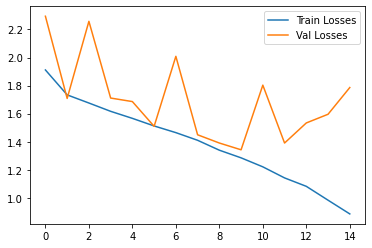

In [ ]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, val_losses, train_accs, val_accs = train_supervised(model, STL10_LABELED_LOADER_TRAIN, F.nll_loss, optimizer, 15, val_loader=STL10_LABELED_LOADER_VAL, device=device)
plt.plot(train_losses, label="Train Losses")
plt.plot(val_losses, label="Val Losses")
plt.legend(loc="best")

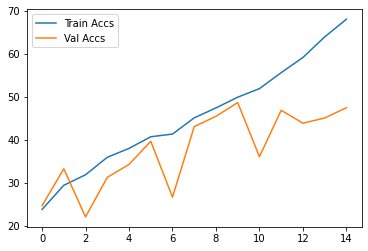

In [ ]:
plt.plot(train_accs, label="Train Accs")
plt.plot(val_accs, label="Val Accs")
plt.legend(loc="best")

In [ ]:
get_accuracies(model, STL10_TEST_LOADER)/len(STL10_TEST_LOADER.dataset)*100

tensor(46.7625, device='cuda:0')

## Training Self Supervised Model

### Training the Representation Learner of the Self Supervised model

In [ ]:
# Examples of augmented images
plt.imshow(STL10_UNLABELED_SET)

In [ ]:
model = BarlowTwins().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_barlo(model, STL10_UNLABELED_LOADER_TRAIN, None, optimizer, 10, val_loader=STL10_UNLABELED_LOADER_VAL, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 236.55213928222656, Val Loss: 184.15635681152344


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 158.8482208251953, Val Loss: 144.63656616210938


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 134.85128784179688, Val Loss: 129.5035400390625


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 121.05902099609375, Val Loss: 116.65279388427734


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 111.7072982788086, Val Loss: 111.2901382446289


  0%|          | 0/2813 [00:00<?, ?it/s]

In [ ]:
loaded_model_barlo = torch.load("/content/drive/MyDrive/Barlo3.pth", map_location=torch.device("cpu"))

In [34]:
class SSL(nn.Module):
  def __init__(self, barlo_model):
    super(SSL, self).__init__()
    self.resnet = barlo_model.backbone
    self.linear = nn.Linear(1000, 10)
  def forward(self, x):
    x = self.resnet(x)
    x = F.relu(x)
    x = self.linear(x)
    return F.log_softmax(x, dim=1)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 2.3456175327301025, Val Loss: 2.138540267944336 Train Accs: 30.599998474121094, Val Accs: 34.20000076293945
Epoch: 1, Train Loss: 2.1333141326904297, Val Loss: 2.0303304195404053 Train Accs: 33.68888854980469, Val Accs: 36.39999771118164
Epoch: 2, Train Loss: 2.0617988109588623, Val Loss: 2.2664332389831543 Train Accs: 34.68888854980469, Val Accs: 31.799999237060547
Epoch: 3, Train Loss: 2.030876636505127, Val Loss: 2.0779216289520264 Train Accs: 35.08888626098633, Val Accs: 36.19999694824219
Epoch: 4, Train Loss: 1.9783481359481812, Val Loss: 1.9714641571044922 Train Accs: 36.31111145019531, Val Accs: 37.599998474121094
Epoch: 5, Train Loss: 1.9836900234222412, Val Loss: 2.1095032691955566 Train Accs: 36.488887786865234, Val Accs: 35.20000076293945
Epoch: 6, Train Loss: 2.0037970542907715, Val Loss: 2.0920004844665527 Train Accs: 37.5111083984375, Val Accs: 35.400001525878906
Epoch: 7, Train Loss: 1.994179129600525, Val Loss: 2.072402000427246 Train Accs: 38.2666

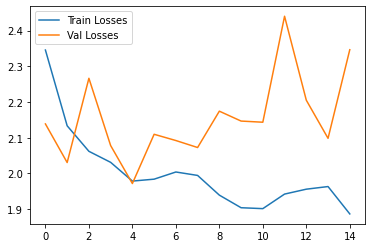

In [ ]:
ssl = SSL(loaded_model_barlo).to(device)
for param in ssl.resnet.parameters():
    param.requires_grad = False
optimizer = torch.optim.Adam(ssl.parameters(), lr=1e-3)
train_losses, val_losses, train_accs, val_accs = train_supervised(ssl, STL10_LABELED_LOADER_TRAIN, F.nll_loss, optimizer, 15, val_loader=STL10_LABELED_LOADER_VAL, device=device)
plt.plot(train_losses, label="Train Losses")
plt.plot(val_losses, label="Val Losses")
plt.legend(loc="best")

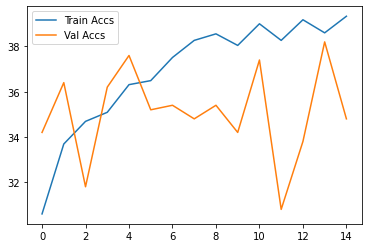

In [ ]:
plt.plot(train_accs, label="Train Accs")
plt.plot(val_accs, label="Val Accs")
plt.legend(loc="best")

In [ ]:
get_accuracies(ssl, STL10_TEST_LOADER)/len(STL10_TEST_LOADER.dataset)*100

tensor(34.5375)

### Visualizing the latent space

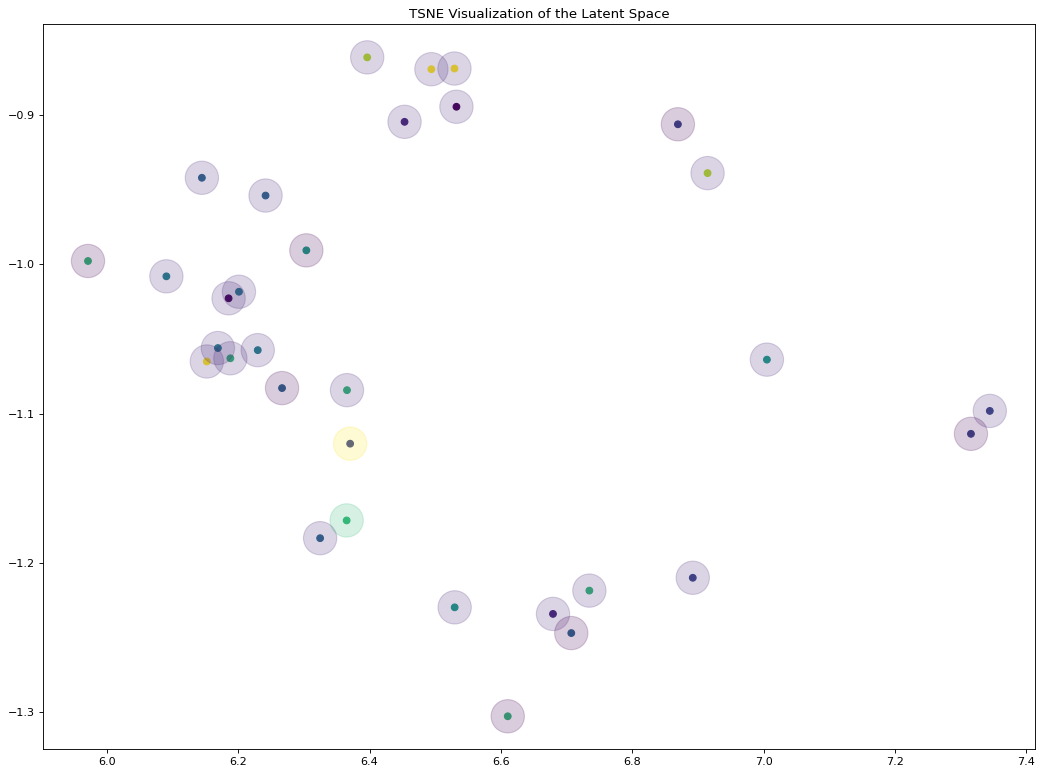

In [85]:
# Random Model on the test set
tsne(SSL(BarlowTwins()), STL10_TEST_LOADER)

The background colors represent the predicted lables of the datapoints. The color of the dots are the true labels

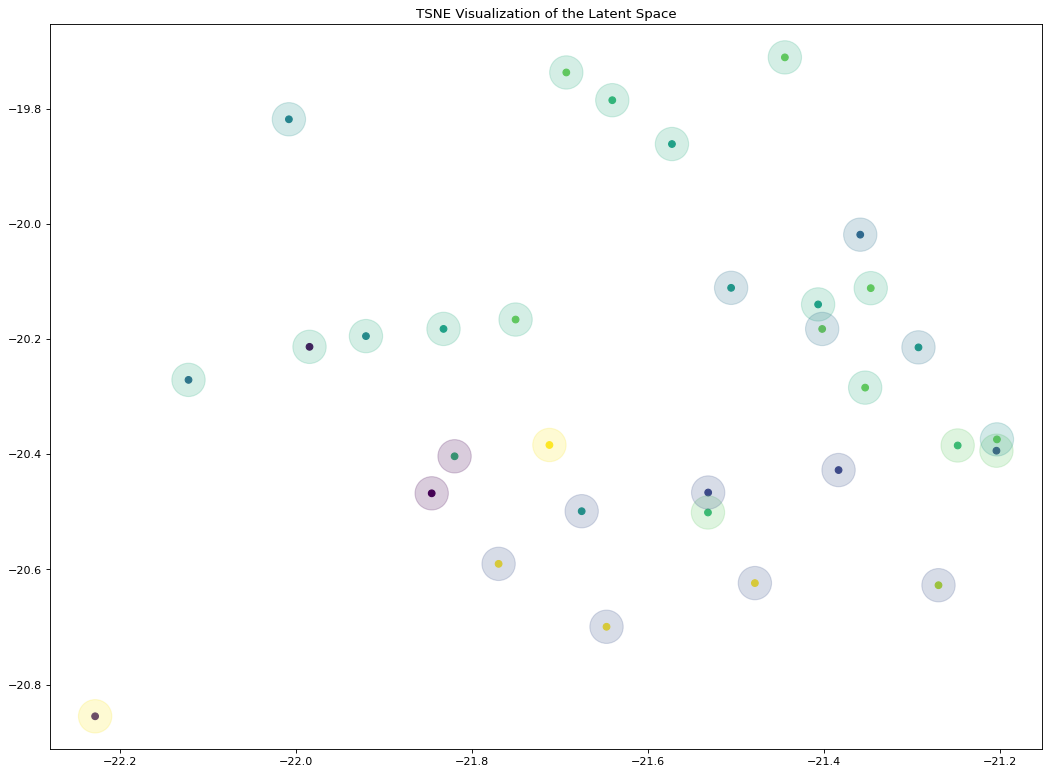

In [86]:
tsne(torch.load("/content/drive/MyDrive/Supervised(epoch_14)SSL.pth", map_location=device), STL10_TEST_LOADER)

It can be clearly seen that the representation after training the feature extractor has instances with the same predicted label close by. The reason why this fact does not perfectly hold for the true labels is attributed to the insufficient computational resources to train the unsupervised model to convergence.

## Training Semi Supervised

In [ ]:
STL10_UNLABELED_SET_NORMAL = STL10("/content/drive/MyDrive/NORMALED_UNLABELED", download=True, transform=transforms.ToTensor(), split="unlabeled")
# STL10_UNLABELED_NORMAL_SUBSET = torch.utils.data.Subset(STL10_UNLABELED_SET_NORMAL, list(range(0, len(STL10_UNLABELED_SET), 5)))
STL10_UNLABELED_LOADER_NORMAL = torch.utils.data.DataLoader(STL10_UNLABELED_SET_NORMAL, batch_size=32, shuffle=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/NORMALED_UNLABELED/stl10_binary.tar.gz to /content/drive/MyDrive/NORMALED_UNLABELED


In [ ]:
semi_model = Net().to(device)
optimizer = torch.optim.Adam(semi_model.parameters(), lr=1e-3)
train_semi_supervised(semi_model, STL10_LABELED_LOADER_TRAIN, STL10_UNLABELED_LOADER_NORMAL, optimizer, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Label

  0%|          | 0/3125 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Label

  0%|          | 0/3125 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Label

  0%|          | 0/3125 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Label

  0%|          | 0/3125 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Label

  0%|          | 0/3125 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Label

  0%|          | 0/3125 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Labeled
Training Label

  0%|          | 0/3125 [00:00<?, ?it/s]

Training Labeled


In [18]:
load_semi_model = torch.load("/content/drive/MyDrive/semi6_f.pth", map_location=device)

In [19]:
# 100k unlabeled images
get_accuracies(load_semi_model, STL10_TEST_LOADER)/len(STL10_TEST_LOADER.dataset)

tensor(0.5503, device='cuda:0')

In [88]:
STL10_UNLABELED_SET_NORMAL = STL10("/content/drive/MyDrive/NORMALED_UNLABELED", download=True, transform=transforms.ToTensor(), split="unlabeled")
STL10_UNLABELED_NORMAL_SUBSET = torch.utils.data.Subset(STL10_UNLABELED_SET_NORMAL, list(range(0, len(STL10_UNLABELED_SET), 50)))
STL10_UNLABELED_LOADER_NORMAL = torch.utils.data.DataLoader(STL10_UNLABELED_NORMAL_SUBSET, batch_size=32, shuffle=True)

semi_model = Net().to(device)
optimizer = torch.optim.Adam(semi_model.parameters(), lr=1e-3)
labeled_loss, unlabeled_loss = train_semi_supervised(semi_model, STL10_LABELED_LOADER_TRAIN, STL10_UNLABELED_LOADER_NORMAL, optimizer, 10, device)

Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Epoch: 0, Labelled Loss: 1.826902985572815, Unlabeled Loss: 0.0


  0%|          | 0/63 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Epoch: 1, Labelled Loss: 1.7595350742340088, Unlabeled Loss: 0.005534748546779156


  0%|          | 0/63 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Epoch: 2, Labelled Loss: 1.5866773128509521, Unlabeled Loss: 0.012843775562942028


  0%|          | 0/63 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Epoch: 3, Labelled Loss: 1.5616528987884521, Unlabeled Loss: 0.014189825393259525


  0%|          | 0/63 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Epoch: 4, Labelled Loss: 1.4239963293075562, Unlabeled Loss: 0.024367069825530052


  0%|          | 0/63 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Epoch: 5, Labelled Loss: 1.292587399482727, Unlabeled Loss: 0.028106117621064186


  0%|          | 0/63 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Epoch: 6, Labelled Loss: 1.1732028722763062, Unlabeled Loss: 0.0329839363694191


  0%|          | 0/63 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Epoch: 7, Labelled Loss: 1.00362229347229, Unlabeled Loss: 0.027435295283794403


  0%|          | 0/63 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Epoch: 8, Labelled Loss: 0.8643845915794373, Unlabeled Loss: 0.04268842190504074


  0%|          | 0/63 [00:00<?, ?it/s]

Training Labeled
Training Labeled
Epoch: 9, Labelled Loss: 0.6653954386711121, Unlabeled Loss: 0.031252648681402206


([1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.8883846998214722,
  1.888384

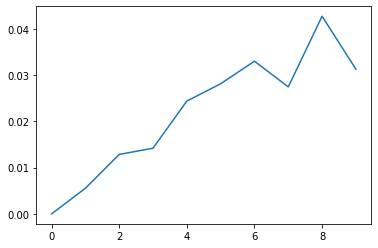

In [93]:
plt.plot(unlabeled_loss)

The unlabeled loss should be increasing (atleast in the initial times). This is because at the very start the model just predicts the unlabeled images randomly and hence allotting the psuedo labels is immaterial. Once the model starts learning something based on the labeled data, does it start getting harder for the psuedo labels to match the true labels.

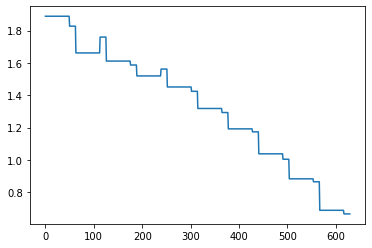

In [92]:
plt.plot(labeled_loss)

The dips clearly show the advantage of mixing supervised and unsupervised training

In [90]:
# 2000 unlabeled images
get_accuracies(semi_model, STL10_TEST_LOADER)/len(STL10_TEST_LOADER.dataset)

tensor(0.4667)

# Summary

The supervised training and semi-supervised training give the best reults.
This is expected as the self-supervised representation learner could not converge with the given model capacity and epochs.
The semi supervised does show great results, and they get better with more unlabeled images you add.

| Model                            | Test Accuracy |
|----------------------------------|---------------|
| Supervised                       | 46.76%        |
| Self Supervised (Barlo) (layers frozen)          | 34.5%         |
| Semi Supervised (100k Unlabeled) | 59.72%        |
| Semi Supervised (10k Unlabeled)  | 51.70%        |
| Semi Supervised (2k Unlabeled)   | 46.67%              |